In [1]:
import pandas as pd
import numpy as np 

%matplotlib inline
import matplotlib
import seaborn as sns
from sklearn.externals import joblib
import random

import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [2]:
base_data = pd.read_csv('./data/policies.csv')

# Select all the policies exp in 201805 to 201807

In [3]:
exp_pols = base_data[(base_data.D_EXP_YRM>=201805)&(base_data.D_EXP_YRM<=201807)
                     &(base_data.LOB=='001-Private Motor')].copy()
print(exp_pols.shape[0])
exp_pols = exp_pols.loc[exp_pols.CONTRACT_TYPE.isin(
        ['Motorcycle TPFT', 'Motorcycle TPO', 'Motorcycle COMP'])==False].copy()
exp_pols = exp_pols.loc[exp_pols.CONTRACT_TYPE!= 'Private High End Cars'].copy()
print(exp_pols.shape[0])

24466
20528


In [4]:
print('Number of total policies expires in 201805 to 201807: ' + str(exp_pols.shape[0]))
print('Number of Agency for these policies: ' + str(exp_pols.SOURCE_CODE.nunique()))

Number of total policies expires in 201805 to 201807: 20528
Number of Agency for these policies: 497


# Key features 

In [5]:
# age, gender, gwp, experian grp, 
# vehicle YRMANF, ZMAKE (To be use: CAPCTY )
continus_features = ['clt_age',  'gwp', 'car_age', 'CAPCTY']
cate_features = ['CLTSEX','ZMAKE', 'PC_M_SG_17_GROUP_ALPHA_I'] # , 'high_end'
key_features = continus_features + cate_features

# Check similarity bwtween 3 groups 

### cancel rate, lapse rate,  nb pol exp in 2017

In [6]:
def get_cancel_rate(dataset):
    nb_renewable = dataset['PCEXP_RNABL_CANC'].sum() + dataset['PCEXP_RNABL_LAPS'].sum(
                        ) + dataset['PCEXP_RNABL_RENW'].sum() + dataset['PCEXP_RNABL_REPL'].sum()
    nb_cancel = dataset['PCEXP_RNABL_CANC'].sum()
    cancel_rate = nb_cancel*1.0/ nb_renewable
    return cancel_rate

def get_lapse_rate(dataset):
    nb_total = dataset['PCEXP_RNABL_LAPS'].sum(
                        ) + dataset['PCEXP_RNABL_RENW'].sum() + dataset['PCEXP_RNABL_REPL'].sum()
    nb_lapse = dataset['PCEXP_RNABL_LAPS'].sum()
    lapse_rate = nb_lapse*1.0/ nb_total
    return lapse_rate

- get the good splitting

In [7]:
def coef_of_var(x):
    return np.std(x)/np.mean(x)

In [8]:
source_codes =  pd.DataFrame(exp_pols.SOURCE_CODE.value_counts(dropna=False)).reset_index(
            ).rename(columns={'index':'SOURCE_CODE', 'SOURCE_CODE':'nb_pols'})
source_codes['group_nb'] = 0

In [9]:
good_seeds = [ 924]

In [10]:
# for j in range(10000):
for j in good_seeds:
    random.seed(j)
    int_list = []
    for i in range(source_codes.shape[0]):
        a = random.randint(0, 2)
        int_list.append(a)
        source_codes.iloc[i, 2] = a
#     display(source_codes.groupby('group_nb').sum())
    exp_pols_wth_grp = exp_pols.merge(source_codes)
    
    #########################
    base_2017 = base_data.loc[(base_data.LOB=='001-Private Motor')&(base_data.D_EXP_YR==2017)].copy()
    base_2017 = base_2017.merge(source_codes)

    agency_grp_stas = pd.DataFrame(columns=['agency_grp', 'nb_exp', 'cancel_rate', 'lapse_rate'])
    agency_grp_stas['agency_grp'] =[0,1,2]

    for grp in [0,1,2]:
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'nb_exp'] = base_2017.loc[base_2017.group_nb==grp].shape[0]
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'cancel_rate'] = get_cancel_rate(
            base_2017.loc[base_2017.group_nb==grp])
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'lapse_rate'] = get_lapse_rate(
            base_2017.loc[base_2017.group_nb==grp])
    

    
    
    var_metric = coef_of_var(source_codes.groupby('group_nb').sum()['nb_pols'].values)*0.1 + coef_of_var(
        agency_grp_stas['cancel_rate'].values)*0.5 + coef_of_var(agency_grp_stas['lapse_rate'].values)
    
#     print("Round %d: "%(j+1) +  str(var_metric))
    
    if((j+1)%100==0):
        print("Round %d finished! "%(j+1))
    
#     if(var_metric<=0.05):
#         print("Seed range 0.05: "+str(j))
    
#     if(var_metric<=0.04):
#         print("Seed range 0.04: "+str(j))
    
    if(var_metric<=0.04):
        print('Random seed: %d'%(j))
        display(source_codes.groupby('group_nb').sum().reset_index())
        display(agency_grp_stas)
        print(var_metric)
#         break

In [11]:
def compare_cate_variable(dataset, value_col, grp_col, nb_top_values, percentage=True):
    top_values = pd.DataFrame(dataset[value_col].value_counts()).reset_index()[:nb_top_values]['index'].values
    
    cate_data = dataset.groupby([value_col, grp_col]).size().reset_index().rename(columns={0:'number'})
    grp_size = cate_data.groupby(['group_nb']).sum().reset_index().rename(columns = {'number':'grp_size'})
    cate_data = cate_data.merge(grp_size)
    cate_data['percentage'] = cate_data['number']*1.0/cate_data['grp_size']
    cate_data = cate_data.loc[cate_data[value_col].isin(top_values)]
    
#     plt.figure(figsize=(16, 9))
    if (percentage == False):
        sns.barplot(x=value_col, y="number", hue=grp_col, data=cate_data)
    else:
        sns.barplot(x=value_col, y="percentage", hue=grp_col, data=cate_data)
    plt.xticks(rotation=45)

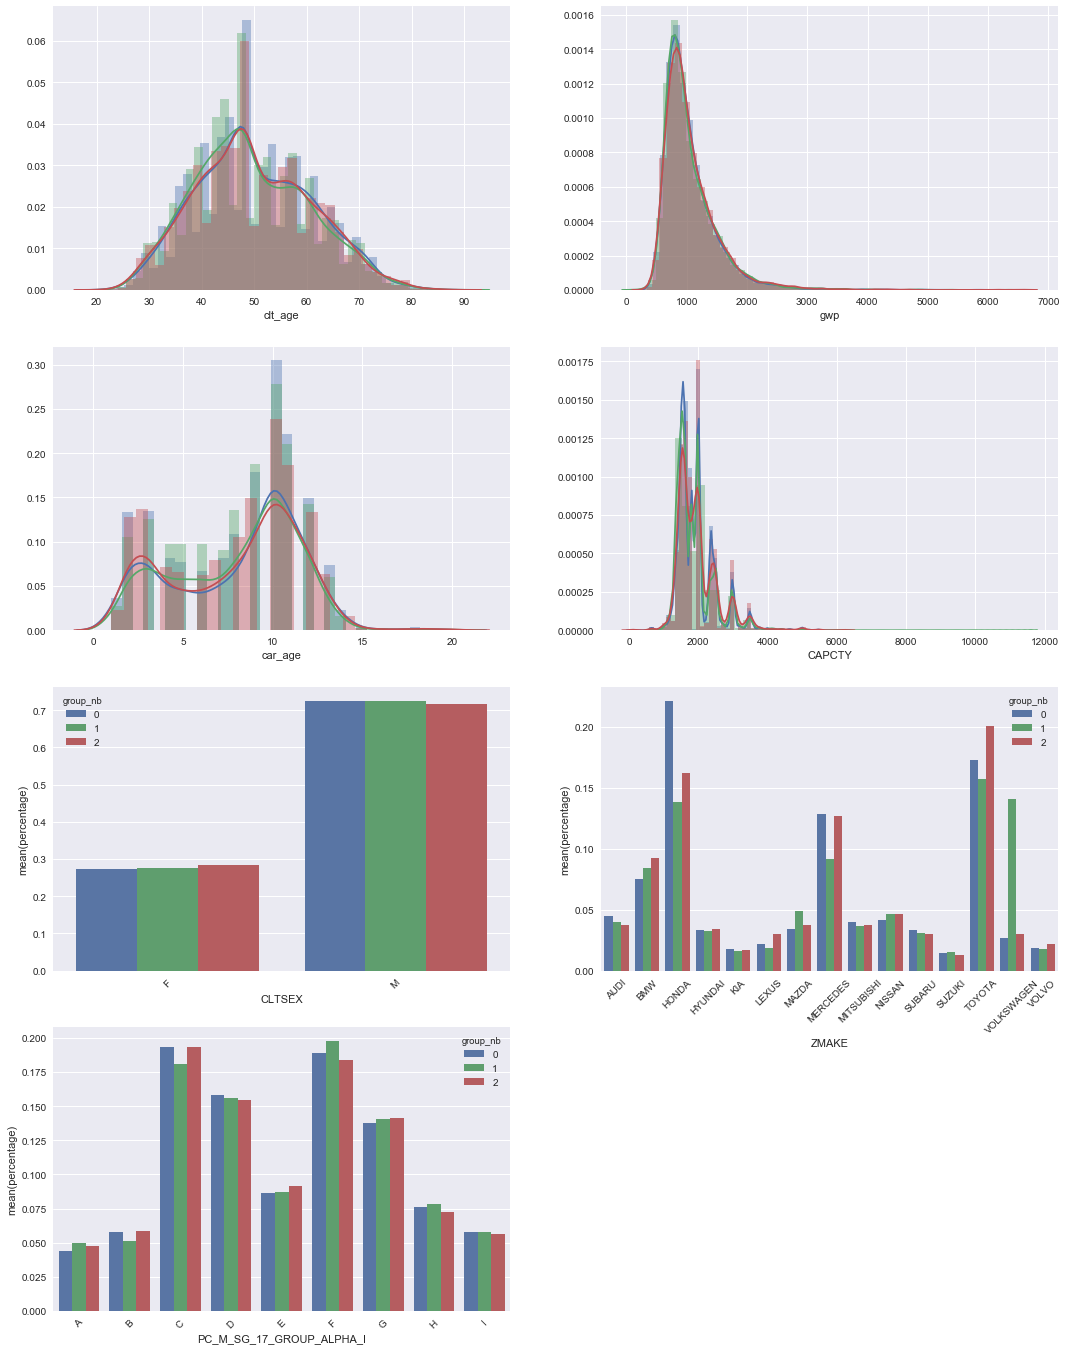

In [12]:
plt.figure(figsize=(18, (len(key_features)/2+1)*6))
i = 1
for col in key_features:
    plt.subplot(len(key_features)/2+1, 2, i)
    if(col in continus_features):
        for grp in [0,1,2]:
            sns.distplot(exp_pols_wth_grp.loc[exp_pols_wth_grp['group_nb']==grp][col])
    else:
        compare_cate_variable(exp_pols_wth_grp, col, 'group_nb', 15)  
    i+=1